# ***RK4***

713
9.881950190852543e-09


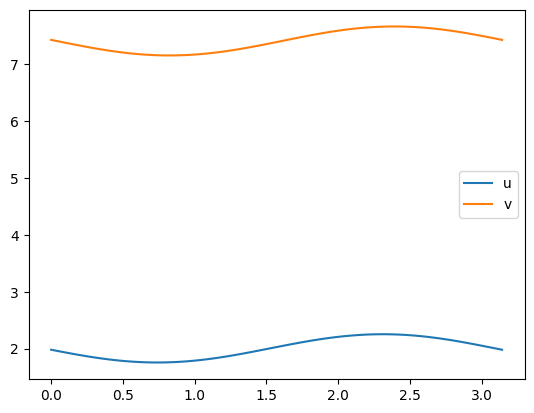

In [ ]:
import pylab
import math
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

bta = 2.1
eps = 0.1
sgm = 1.5
a,b=(0.01, 0.6)
t = np.linspace(0,np.pi,100)
def FG(t,w):
  u,v=w
  return [math.sin(t)**2 - bta*u/(1+v), -math.cos(t)**2 + sgm*u/(1+v)+eps/(1+v)]

eta=0.01; epsilon=1e-8;

k=0; err=1;
u0 = [a,b]
solution = solve_ivp(FG, [0, np.pi], u0,dense_output=True).sol(t)
u = solution[0]
v = solution[1]
while (err>epsilon):
  solution = solve_ivp(FG, [0, np.pi], u0,dense_output=True).sol(t)
  u = solution[0]
  v = solution[1]
  y_end=[u[-1],v[-1]]
  err=np.linalg.norm(np.array(u0) - np.array(y_end) ,2)
  u0=y_end
  k=k+1



print(k)
print(err)

plt.plot(t, u, label='u')
plt.plot(t, v, label='v')
plt.legend(loc='best')
plt.show()



```
# This is formatted as code
```

# ***dde installation***

In [ ]:
pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.7 MB/s eta 0:00:00


In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.7 MB/s eta 0:00:00


# ***Model1***

Compiling model...
Building feed-forward neural network...
'build' took 0.117394 s

'compile' took 3.166823 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.79e+02, 1.72e+02, 8.88e-14, 1.42e-14]    [1.79e+02, 1.72e+02, 8.88e-14, 1.42e-14]    []  
1000      [5.27e+01, 1.60e+02, 3.55e-15, 8.88e-14]    [5.27e+01, 1.60e+02, 3.55e-15, 8.88e-14]    []  
2000      [3.48e+01, 1.55e+02, 1.42e-14, 5.68e-14]    [3.48e+01, 1.55e+02, 1.42e-14, 5.68e-14]    []  

Best model at step 2000:
  train loss: 1.90e+02
  test loss: 1.90e+02
  test metric: []

'train' took 14.952420 s

Compiling model...
'compile' took 3.956232 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
2000      [3.48e+01, 1.55e+02, 1.42e-14, 5.68e-14]    [3.48e+01, 1.55e+02, 1.42e-14, 5.68e-14]    []  
2007      [7.86e+01, 9.38e+01, 5.55e-13, 1.74e-13]    [7.

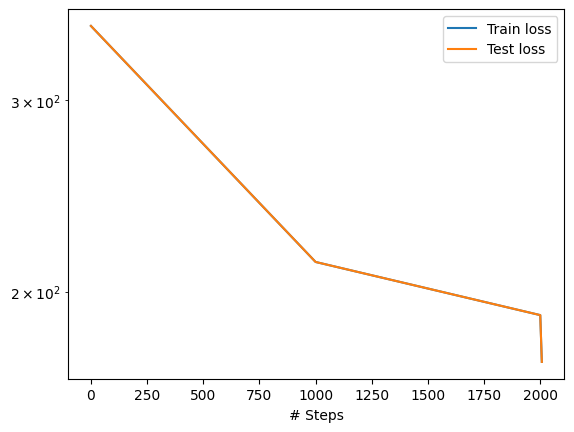

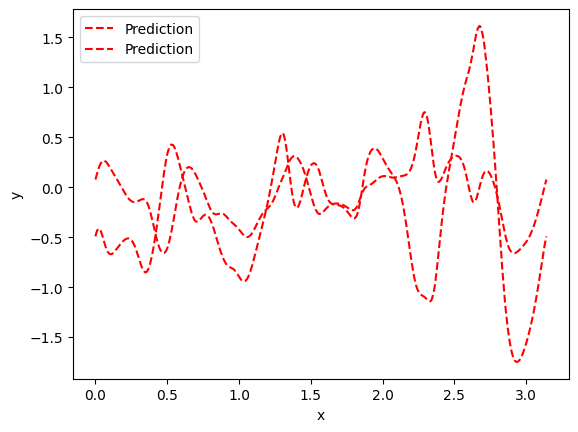

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import deepxde as dde

import tensorflow_addons as tfa

from tensorflow_addons import activations


bta = 2.1
eps = 0.1
sgm = 1.5

def f(t,u,v):
  return tf.sin(t)**2-bta*(u/(1+v))
def g(t,u,v):
  return -tf.cos(t)**2+sgm*(u/(1+v))+eps/(1+v)



def ode_system(t, y):
    u, v = y[:, 0:1], y[:, 1:]
    du_t = tf.gradients(u, t)[0]
    dv_t = tf.gradients(v, t)[0]
    return [du_t - f(t,u,v), dv_t - g(t,u,v)]

def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0,np.pi)
bc_u = dde.PeriodicBC(geom, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0)
bc_v = dde.PeriodicBC(geom, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1)
layer_size = [1] + [20] * 3 + [2]
#activation = "tanh"
activation = tfa.activations.snake
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
def feature_transform(inputs):
# Periodic BC in x
  P = np.pi
  w = 2 * np.pi/P
  t = w*inputs
  return tf.concat(
    (
        tf.math.cos(t),
        tf.math.sin(t),
        tf.math.cos(2 * t),
        tf.math.sin(2 * t),
        tf.math.cos(3 * t),
        tf.math.sin(3 * t),
        tf.math.cos(4 * t),
        tf.math.sin(4 * t),
        tf.math.cos(5 * t),
        tf.math.sin(5 * t),
        # tf.math.cos(6 * t),
        # tf.math.sin(6 * t),
        # tf.math.cos(7 * x),
        # tf.math.sin(7 * x),
        # tf.math.cos(8 * x),
        # tf.math.sin(8 * x),
        # tf.math.cos(9 * x),
        # tf.math.sin(9 * x),
        # tf.math.cos(10 * x),
        # tf.math.sin(10 * x),
    ),
    axis=1,
)



############################################################
net.apply_feature_transform(feature_transform)

data = dde.data.PDE(geom,ode_system, [bc_u, bc_v],num_domain=400, num_boundary=2)
model1 = dde.Model(data, net)
model1.compile("adam", lr=0.001)
losshistory, train_state = model1.train(epochs=2000)
model1.compile("L-BFGS-B")
losshistory, train_state = model1.train()


dde.saveplot(losshistory, train_state, issave=True, isplot=True)


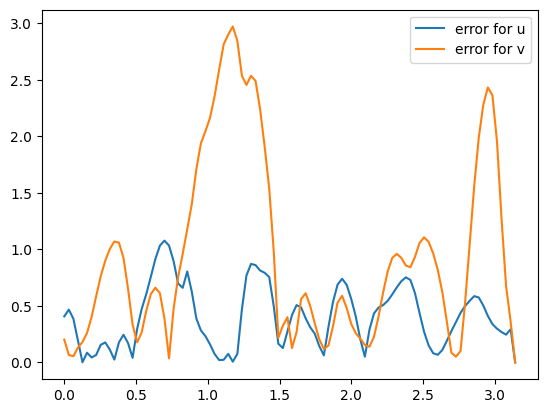

[ 4.89e+00 1.25e+01 ]


In [ ]:
from matplotlib import pyplot as plt

N=100
hpas=np.linspace(0, np.pi, N)
err1=np.zeros(N)
err2=np.zeros(N)
err_gu=0
err_gv=0

for i in range(N-1):
  pred=model1.predict(np.array([[hpas[i]]]))
  err1[i]=np.sqrt(np.power(pred[0, 0]-u[i],2))
  err2[i]=np.sqrt(np.power(pred[0, 1]-v[i],2))
  err_gu+=(np.power(pred[0, 0]-u[i],2))
  err_gv+=(np.power(pred[0, 1]-v[i],2))

plt.plot(hpas, err1, label='error for u')
plt.plot(hpas, err2, label='error for v')
plt.legend(loc='best')
plt.show()

print("[",np.format_float_scientific(np.sqrt(err_gu),2),np.format_float_scientific(np.sqrt(err_gv),2),"]")


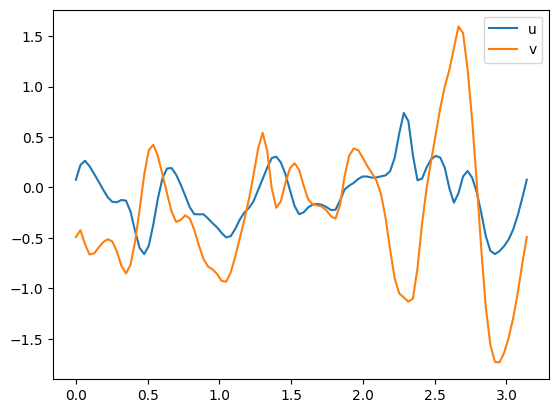

In [ ]:
from matplotlib import pyplot as plt

N=100
hpas=np.linspace(0, np.pi, N)
pu=np.zeros(N)
pv=np.zeros(N)
for i in range(N):
  pred=model1.predict(np.array([[hpas[i]]]))
  pu[i]=pred[0, 0]
  pv[i]=pred[0, 1]
plt.plot(hpas, pu, label='u')
plt.plot(hpas, pv, label='v')
plt.legend(loc='best')
plt.show()

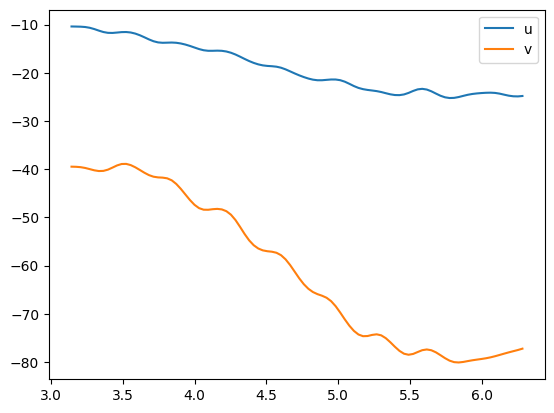

In [ ]:
from matplotlib import pyplot as plt

N=100
hpas=np.linspace(np.pi, 2*np.pi, N)
pu=np.zeros(N)
pv=np.zeros(N)
for i in range(N):
  pred=model1.predict(np.array([[hpas[i]]]))
  pu[i]=pred[0, 0]
  pv[i]=pred[0, 1]
plt.plot(hpas, pu, label='u')
plt.plot(hpas, pv, label='v')
plt.legend(loc='best')
plt.show()

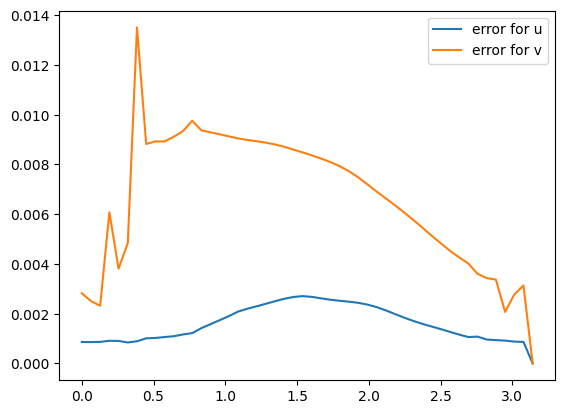

In [ ]:
from matplotlib import pyplot as plt

uk = np.loadtxt('u.txt')
vk = np.loadtxt('v.txt')


N=50
hpas=np.linspace(0, np.pi, N)
err1=np.zeros(N)
err2=np.zeros(N)
for i in range(N-1):
  pred=model1.predict(np.array([[hpas[i]]]))
  err1[i]=np.sqrt(np.power(u[i]-uk[i],2))
  err2[i]=np.sqrt(np.power(v[i]-vk[i],2))

plt.plot(hpas, err1, label='error for u')
plt.plot(hpas, err2, label='error for v')
plt.legend(loc='best')
plt.show()

# ***Model2***

Compiling model...
Building feed-forward neural network...
'build' took 0.058420 s

'compile' took 1.336970 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.75e-01, 4.51e-01, 3.34e-02, 2.54e-02]    [9.75e-01, 4.51e-01, 3.34e-02, 2.54e-02]    []  
1000      [1.75e-03, 7.58e-05, 2.04e-05, 2.52e-06]    [1.75e-03, 7.58e-05, 2.04e-05, 2.52e-06]    []  
2000      [6.93e-04, 1.92e-04, 8.68e-08, 9.30e-06]    [6.93e-04, 1.92e-04, 8.68e-08, 9.30e-06]    []  
3000      [3.72e-04, 4.84e-04, 5.40e-05, 1.78e-03]    [3.72e-04, 4.84e-04, 5.40e-05, 1.78e-03]    []  
4000      [4.88e-05, 9.48e-05, 1.02e-07, 3.95e-07]    [4.88e-05, 9.48e-05, 1.02e-07, 3.95e-07]    []  

Best model at step 4000:
  train loss: 1.44e-04
  test loss: 1.44e-04
  test metric: []

'train' took 11.202523 s

Compiling model...
'compile' took 1.811779 s

Training model...

Step      Train loss                                  Test loss 

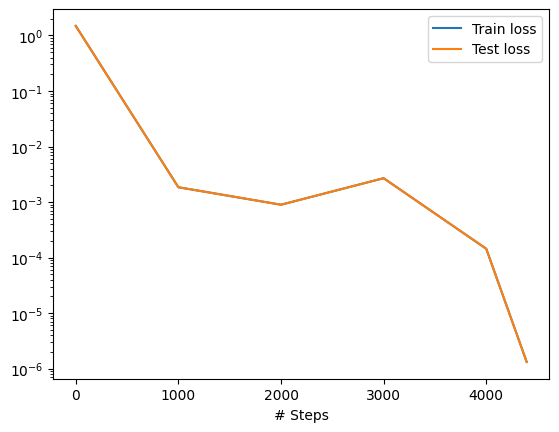

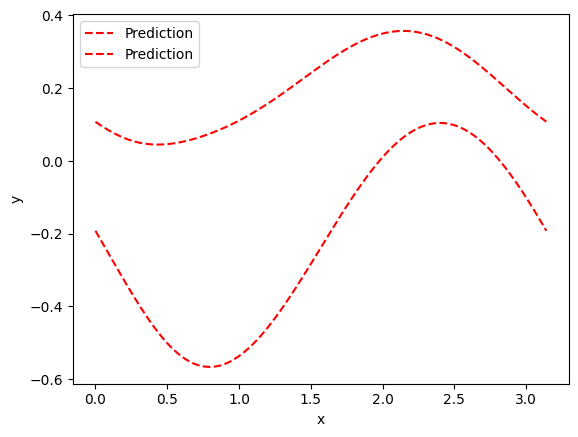

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import deepxde as dde

import tensorflow_addons as tfa

from tensorflow_addons import activations




n=1
def f(t,u,v):
  bta = 2.1
  eps = 0.1
  sgm = 1.5
  return tf.sin(t)**2-bta*(u/(1+v))
def g(t,u,v):
  bta = 2.1
  eps = 0.1
  sgm = 1.5
  return -tf.cos(t)**2+sgm*(u/(1+v))+eps/(1+v)



def ode_system(t, y):
    u, v = y[:, 0:1], y[:, 1:]
    du_t = tf.gradients(u, t)[0]
    dv_t = tf.gradients(v, t)[0]
    return [du_t - f(t,u,v), dv_t - g(t,u,v)]

def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0,np.pi)
bc_u = dde.PeriodicBC(geom, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0)
bc_v = dde.PeriodicBC(geom, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1)
layer_size = [1] + [40] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
def feature_transform(inputs):
# Periodic BC in x
  P = np.pi
  w = 2 * np.pi / P
  t = w*inputs[:,:1]
  return tf.concat(
    (
        tf.math.cos(t),
        tf.math.sin(t),
        tf.math.cos(2 * t),
        tf.math.sin(2 * t),
        tf.math.cos(3 * t),
        tf.math.sin(3 * t),
        tf.math.cos(4 * t),
        tf.math.sin(4 * t),
        tf.math.cos(5 * t),
        tf.math.sin(5 * t),
        # tf.math.cos(6 * t),
        # tf.math.sin(6 * t),
        # tf.math.cos(7 * x),
        # tf.math.sin(7 * x),
        # tf.math.cos(8 * x),
        # tf.math.sin(8 * x),
        # tf.math.cos(9 * x),
        # tf.math.sin(9 * x),
        # tf.math.cos(10 * x),
        # tf.math.sin(10 * x),
    ),
    axis=1,
)



############################################################
#net.apply_feature_transform(feature_transform)

data = dde.data.PDE(geom,ode_system, [bc_u, bc_v],num_domain=400, num_boundary=2)
model2 = dde.Model(data, net)
model2.compile("adam", lr=0.001)
losshistory, train_state = model2.train(epochs=4000)
model2.compile("L-BFGS-B")
losshistory, train_state = model2.train()


dde.saveplot(losshistory, train_state, issave=True, isplot=True)


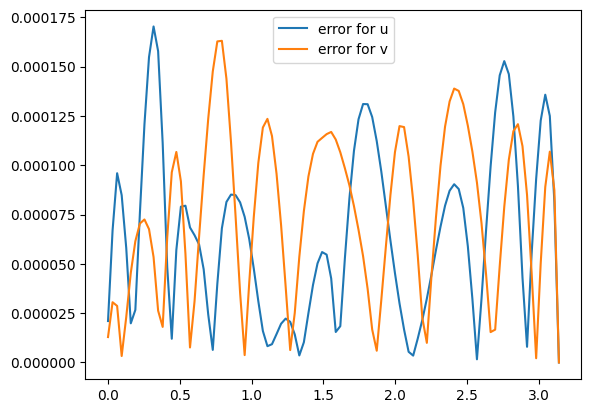

In [ ]:
from matplotlib import pyplot as plt

N=100
hpas=np.linspace(0, np.pi, N)
err1=np.zeros(N)
err2=np.zeros(N)
for i in range(N-1):
  pred=model2.predict(np.array([[hpas[i]]]))
  err1[i]=np.sqrt(np.power(pred[0, 0]-u[i],2))
  err2[i]=np.sqrt(np.power(pred[0, 1]-v[i],2))

plt.plot(hpas, err1, label='error for u')
plt.plot(hpas, err2, label='error for v')
plt.legend(loc='best')
plt.show()

# ***Model3***

Compiling model...
Building feed-forward neural network...
'build' took 0.169007 s

'compile' took 3.887183 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.09e+00, 8.56e-01, 3.32e-01, 3.98e-01]    [1.09e+00, 8.56e-01, 3.32e-01, 3.98e-01]    []  
1000      [3.80e-05, 2.62e-05, 8.41e-08, 2.37e-07]    [3.80e-05, 2.62e-05, 8.41e-08, 2.37e-07]    []  
2000      [3.12e-05, 1.81e-05, 4.33e-07, 5.15e-08]    [3.12e-05, 1.81e-05, 4.33e-07, 5.15e-08]    []  
3000      [2.73e-05, 1.19e-05, 3.61e-08, 2.51e-08]    [2.73e-05, 1.19e-05, 3.61e-08, 2.51e-08]    []  
4000      [4.48e-05, 2.17e-05, 3.07e-07, 6.16e-06]    [4.48e-05, 2.17e-05, 3.07e-07, 6.16e-06]    []  

Best model at step 3000:
  train loss: 3.93e-05
  test loss: 3.93e-05
  test metric: []

'train' took 36.780251 s

Compiling model...
'compile' took 5.282905 s

Training model...

Step      Train loss                                  Test loss 

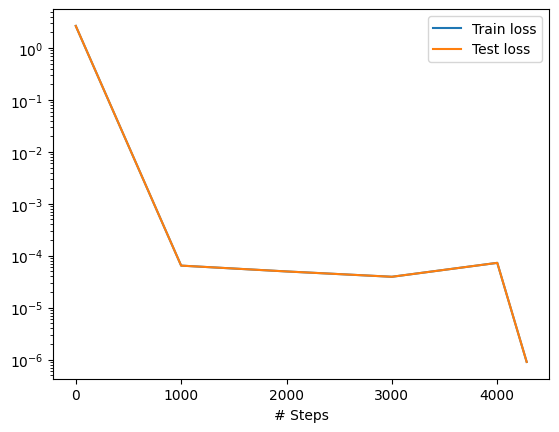

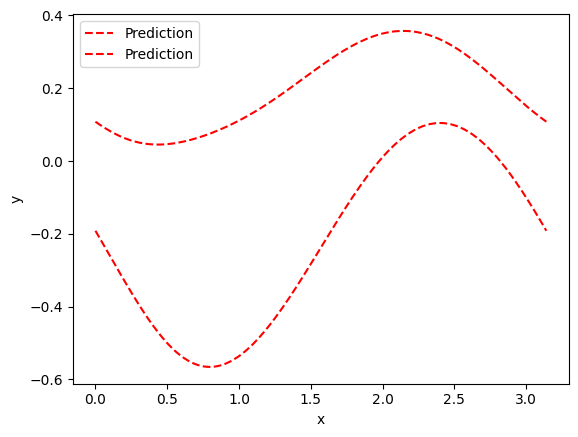

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import deepxde as dde

import tensorflow_addons as tfa

from tensorflow_addons import activations




n=1
def f(t,u,v):
  bta = 2.1
  eps = 0.1
  sgm = 1.5
  return tf.sin(t)**2-bta*(u/(1+v))
def g(t,u,v):
  bta = 2.1
  eps = 0.1
  sgm = 1.5
  return -tf.cos(t)**2+sgm*(u/(1+v))+eps/(1+v)



def ode_system(t, y):
    u, v = y[:, 0:1], y[:, 1:]
    du_t = tf.gradients(u, t)[0]
    dv_t = tf.gradients(v, t)[0]
    return [du_t - f(t,u,v), dv_t - g(t,u,v)]

def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0,np.pi)
bc_u = dde.PeriodicBC(geom, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0)
bc_v = dde.PeriodicBC(geom, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1)
layer_size = [1] + [50] * 5 + [2]
activation = tfa.activations.snake
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
def feature_transform(inputs):
# Periodic BC in x
  P = np.pi
  w = 2 * np.pi / P
  t = w*inputs[:,:1]
  return tf.concat(
    (
        tf.math.cos(t),
        tf.math.sin(t),
        tf.math.cos(2 * t),
        tf.math.sin(2 * t),
        tf.math.cos(3 * t),
        tf.math.sin(3 * t),
        tf.math.cos(4 * t),
        tf.math.sin(4 * t),
        tf.math.cos(5 * t),
        tf.math.sin(5 * t),
        # tf.math.cos(6 * t),
        # tf.math.sin(6 * t),
        # tf.math.cos(7 * x),
        # tf.math.sin(7 * x),
        # tf.math.cos(8 * x),
        # tf.math.sin(8 * x),
        # tf.math.cos(9 * x),
        # tf.math.sin(9 * x),
        # tf.math.cos(10 * x),
        # tf.math.sin(10 * x),
    ),
    axis=1,
)



############################################################
#net.apply_feature_transform(feature_transform)

data = dde.data.PDE(geom,ode_system, [bc_u, bc_v],num_domain=200, num_boundary=2)
model3 = dde.Model(data, net)
model3.compile("adam", lr=0.001)
losshistory, train_state = model3.train(epochs=4000)
model3.compile("L-BFGS-B")
losshistory, train_state = model3.train()


dde.saveplot(losshistory, train_state, issave=True, isplot=True)


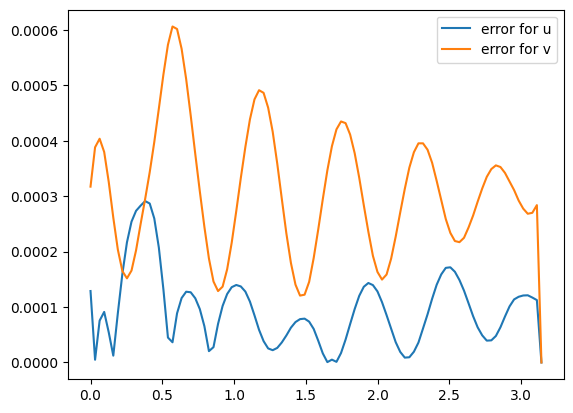

In [ ]:
from matplotlib import pyplot as plt

N=100
hpas=np.linspace(0, np.pi, N)
err1=np.zeros(N)
err2=np.zeros(N)
for i in range(N-1):
  pred=model3.predict(np.array([[hpas[i]]]))
  err1[i]=np.sqrt(np.power(pred[0, 0]-u[i],2))
  err2[i]=np.sqrt(np.power(pred[0, 1]-v[i],2))

plt.plot(hpas, err1, label='error for u')
plt.plot(hpas, err2, label='error for v')
plt.legend(loc='best')
plt.show()

NameError: ignored

In [ ]:
print(1)

1


In [ ]:
_

''